In [1]:
import numpy as np
from scipy.optimize import fsolve
from casadi import *
import matplotlib.pyplot as plt
import os

In [2]:
# directory for figure saving
folder = './Figures'
save_type = '.png'

if not os.path.exists(folder):
    os.makedirs(folder)

In [3]:
def model(x, u, sigma, std, xs=None, us=None, noise=False):
    """Compute the right-hand side of the ODEs
    
    Args:
        x (array-like): State vector
        u (array-like): Input vector
        sigma (array-like): Parameters
        xs (array-like, optional): steady-state
        us (array-like, optional): steady-state input
    
    Returns:
        array-like: dx/dt    
    """
    if xs is not None:
        # Assume x is in deviation variable form
        x = [x[i] + xs[i] for i in range(4)]
        
    if us is not None:
        # Assume u is in deviation variable form
        u = [u[i] + us[i] for i in range(2)]
        
    dxdt = [0.] * 4
    dxdt[0] = u[0] - x[0] - sigma[0] * x[0] * x[1]                           
    dxdt[1] = u[1] - x[1] - sigma[0] * x[0] * x[1] - sigma[1] * x[1] * x[2]  
    dxdt[2] = -x[2] + sigma[0] * x[0] * x[1] - sigma[1] * x[1] * x[2]        
    dxdt[3] = -x[3] + sigma[1] * x[1] * x[2]                                 
    
    if noise is True:
        dxdt[0] += np.random.normal(0, std[0], 1)[0]
        dxdt[1] += np.random.normal(0, std[1], 1)[0]
        dxdt[2] += np.random.normal(0, std[2], 1)[0]
        dxdt[3] += np.random.normal(0, std[3], 1)[0]
    
    return dxdt

In [4]:
def noise_study(model, xs, us, ratio, T, N, dt, sigma, std, Q, R, ulb, uub, num_time_steps_sim, num_trials, nx, nu):
    """
    The large wrapper function for convenience in studying the noise effect of MPC
    
    """
    
    def solve_mpc(current_state):
        """Solve MPC provided the current state, i.e., this 
        function is u = h(x), which is the implicit control law of MPC.

        Args:
            current_state (array-like): current state

        Returns:
            tuple: current input and return status pair
        """

        # Set the lower and upper bound of the decision variable
        # such that s0 = current_state
        for i in range(nx):
            zlb[i] = current_state[i]
            zub[i] = current_state[i]
        sol_out = solver(lbx=zlb, ubx=zub, lbg=g_bnd, ubg=g_bnd)
        return (np.array(sol_out['x'][nx:(nx+nu)]), solver.stats()['return_status'])

    """
    Main block
    """
    # MPC steady state array
    xs_MPC = np.zeros((num_trials, nx))
    
    # Figure plotting
    plt.figure(figsize=[14, 14])
    fig, axs = plt.subplots((nx+nu), 1, figsize=[10, 10])
    
    for trial in range(num_trials):
        # CasADi with symbolics
        t = SX.sym("t", 1, 1)
        x = SX.sym("x", nx, 1)
        u = SX.sym("u", nu, 1)
        ode = vertcat(*model(x, u, sigma, std, xs=xs, us=us, noise=True))

        # models
        f = {'x': x, 't':t, 'p':u , 'ode':ode}
        Phi = integrator("Phi", "cvodes", f, {'tf': dt})
        system = Phi

        # Define the decision variable and constraints
        q = vertcat(*[MX.sym(f'u{i}', nu, 1) for i in range(N)])
        s = vertcat(*[MX.sym(f'x{i}', nx, 1) for i in range(N+1)])
        z = []
        zlb = []
        zub = []
        constraints = []

        # Create a function
        cost = 0.

        for i in range(N):
            s_i = s[nx*i:nx*(i+1)]
            s_ip1 = s[nx*(i+1):nx*(i+2)]
            q_i = q[nu*i:nu*(i+1)]

            # Decision variable
            zlb += [-np.inf] * nx
            zub += [np.inf] * nx
            zlb += ulb
            zub += uub

            z.append(s_i)
            z.append(q_i)

            xt_ip1 = Phi(x0=s_i, p=q_i)['xf']
            cost += s_i.T @ Q @ s_i + q_i.T @ R @ q_i
            constraints.append(xt_ip1 - s_ip1)

        # s_N
        z.append(s_ip1)
        zlb += [-np.inf] * nx
        zub += [np.inf] * nx

        constraints = vertcat(*constraints)
        variables = vertcat(*z)

        # Create the optmization problem
        g_bnd = np.zeros(N*nx)
        nlp = {'f': cost, 'g': constraints, 'x': variables}
        opt = {'print_time': 0, 'ipopt.print_level': 0, 'ipopt.acceptable_tol': 1e-3}
        solver = nlpsol('solver', 'ipopt', nlp, opt)

        # Store the system states and control actions applied to the system
        # in array
        state_history = np.zeros((num_time_steps_sim+1, nx))
        input_history = np.zeros((num_time_steps_sim+1, nu))

        # Set current state - using deviation variables
        state_history[0, :] = np.array([0.5, 0.0, 0.7, 0.7]) - xs
        current_state = state_history[0, :]

        # Time array for plotting
        time = [i*dt for i in range(num_time_steps_sim+1)]

        # Closed-loop simulation
        for k in range(num_time_steps_sim):

            print(f'Current time: {k*dt}')
            current_control, status = solve_mpc(current_state)
            print(f'Solver status: {status}')

            # Advance the simulation one time step
            # Set current_state to be the state at the next time steps
            current_state = np.array(system(x0=current_state, p=current_control)['xf'])

            current_state = current_state.reshape((nx,))
            current_control = current_control.reshape((nu,))

            # Save data for plotting
            input_history[k, :] = current_control
            state_history[k+1:k+2, :] = current_state

        # Save the last control one more time for plotting
        input_history[-1, :] = current_control
        
        # deliverables
        for ii in range(nx):
            xs_MPC[trial, ii] = np.mean(state_history[-5:-1, ii])

        # Plotting
        t_max = min(5, num_time_steps_sim*dt)
        for j in range(nx):
            axs[j].plot(time, state_history[:, j]+xs[j], 'r-', alpha=0.5)
            axs[j].plot([time[0], time[-1]], [xs[j], xs[j]], 'r--')
            axs[j].plot([time[0], time[-1]], [xs[j] * (1 + ratio), xs[j] * (1 + ratio)], 'b--', alpha=0.7)
            axs[j].plot([time[0], time[-1]], [xs[j] * (1 - ratio), xs[j] * (1 - ratio)], 'b--', alpha=0.7)
            axs[j].set_ylabel(f'$x_{j+1}$')
            axs[j].set_xlim([0, t_max])

        for j in range(nu):
            axs[j+nx].step(time, input_history[:, j]+us[j], 'r-', alpha=0.5, where='post')
            axs[j+nx].step([time[0], time[-1]], [us[j], us[j]], 'r--', alpha=0.5, where='post')
            axs[j+nx].set_ylabel(f'$u_{j+1}$')
            axs[j+nx].set_xlim([0, t_max])
            
    axs[-1].set_xlabel('Time')
    ttl = f"MPC Solution for the Chemical Reaction Problem with Uncertainty Ratio Q = {round(ratio, 2)}"
    axs[0].set_title(ttl)

    # save
    save_path = folder + '/' + ttl + save_type
    plt.savefig(save_path)
    
    # deliverables
    # remaining state deviation
    xs_Q_1 = np.mean(xs_MPC[:, 0])
    xs_Q_2 = np.mean(xs_MPC[:, 1])
    xs_Q_3 = np.mean(xs_MPC[:, 2])
    xs_Q_4 = np.mean(xs_MPC[:, 3])
    # summed errors
    se_1 = np.sum(np.abs(xs_MPC[:, 0]) / xs[0])
    se_2 = np.sum(np.abs(xs_MPC[:, 1]) / xs[1])
    se_3 = np.sum(np.abs(xs_MPC[:, 2]) / xs[2])
    se_4 = np.sum(np.abs(xs_MPC[:, 3]) / xs[3])
    
    return xs_Q_1, xs_Q_2, xs_Q_3, xs_Q_4, se_1, se_2, se_3, se_4

In [5]:
# Parameters (used in optimal control problem later as well)
T = 10.0
N = 100
dt = T/N

num_time_steps_sim = 20  # number of time steps in simulation

In [6]:
sigma = [1.0, 0.4]
std = []

# Get the steady-state
us = np.array([1, 2.4310])
f = lambda x: model(x, us, sigma, std, noise=False)
xs, _, flag, _ = fsolve(f, [0.4, 1.6, 0.38, 0.24], full_output=True)

print(f'xs = {xs}')
print(f'Exit flag: {flag}')

xs = [0.38743051 1.58110806 0.37524704 0.23732245]
Exit flag: 1


In [7]:
# constrains
Q = np.eye(4) * 5.0
R = np.array([[1.25, 0.5], 
              [0.5, 1.25]])

ulb = list(-us)
uub = list(np.array([10., 15.])-us)

In [8]:
us = np.array([1, 2.4310])
ulb = list(-us)
uub = list(np.array([10., 15.])-us)

print(ulb)
print(uub)

a = np.array([0.5, 0.0, 0.7, 0.7]) - xs
print(a)
print(dt)

[-1.0, -2.431]
[9.0, 12.568999999999999]
[ 0.11256949 -1.58110806  0.32475296  0.46267755]
0.1


*****************************
Starting to solve for Q = 0.0
*****************************
Current time: 0.0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: So

Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeed

Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succee

Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeed

Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
*****************************
Starting to solve for Q = 0.01
*****************************
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Cur

Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succee

Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succee

Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver statu

Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
*****************************
Starting to solve for Q = 0.1
*****************************
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Curr

Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succee

Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succee

Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solved_To_Acceptable_Level
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
S

Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succeeded
Current time: 1.1
Solver status: Solve_Succeeded
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver st

Solver status: Solve_Succeeded
Current time: 1.3
Solver status: Solve_Succeeded
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
Current time: 1.5
Solver status: Solve_Succeeded
Current time: 1.6
Solver status: Solve_Succeeded
Current time: 1.7000000000000002
Solver status: Solve_Succeeded
Current time: 1.8
Solver status: Solve_Succeeded
Current time: 1.9000000000000001
Solver status: Solve_Succeeded
Current time: 0.0
Solver status: Solve_Succeeded
Current time: 0.1
Solver status: Solve_Succeeded
Current time: 0.2
Solver status: Solve_Succeeded
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
Current time: 0.4
Solver status: Solve_Succeeded
Current time: 0.5
Solver status: Solve_Succeeded
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
Current time: 0.8
Solver status: Solve_Succeeded
Current time: 0.9
Solver status: Solve_Succeeded
Current time: 1.0
Solver status: Solve_Succee

<Figure size 1008x1008 with 0 Axes>

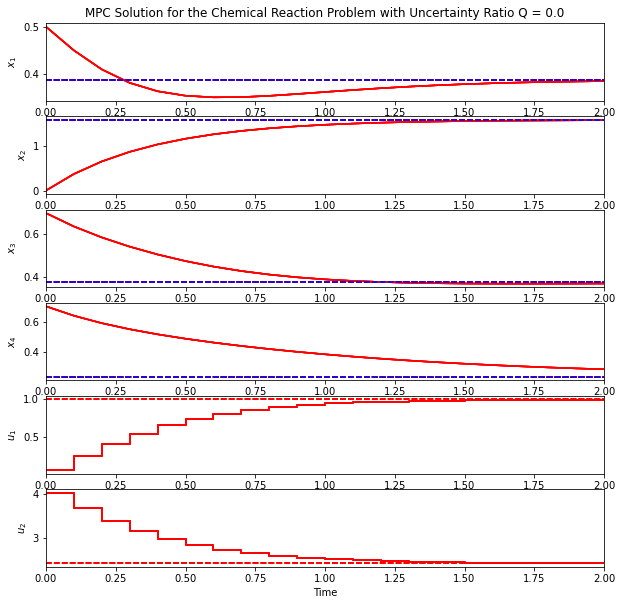

<Figure size 1008x1008 with 0 Axes>

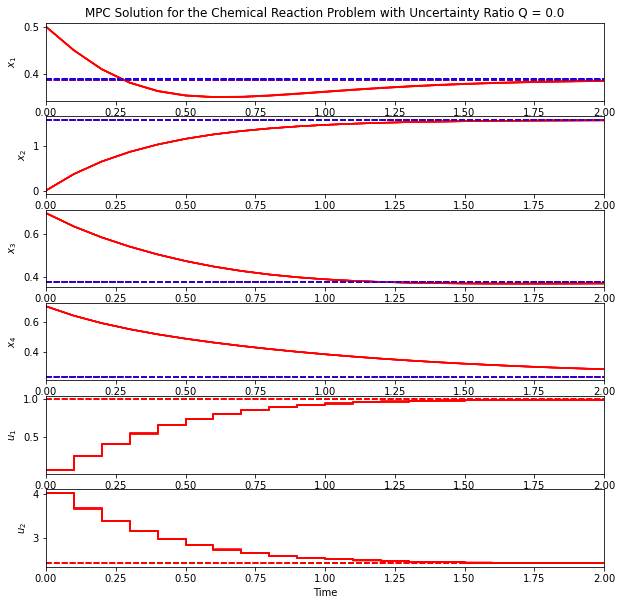

<Figure size 1008x1008 with 0 Axes>

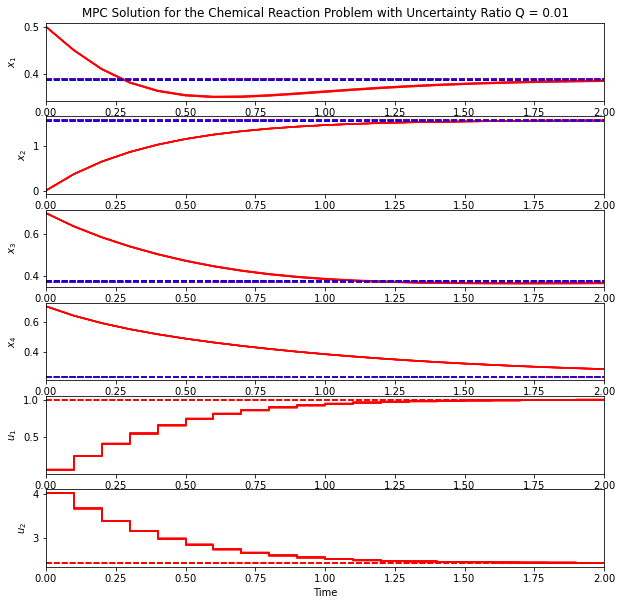

<Figure size 1008x1008 with 0 Axes>

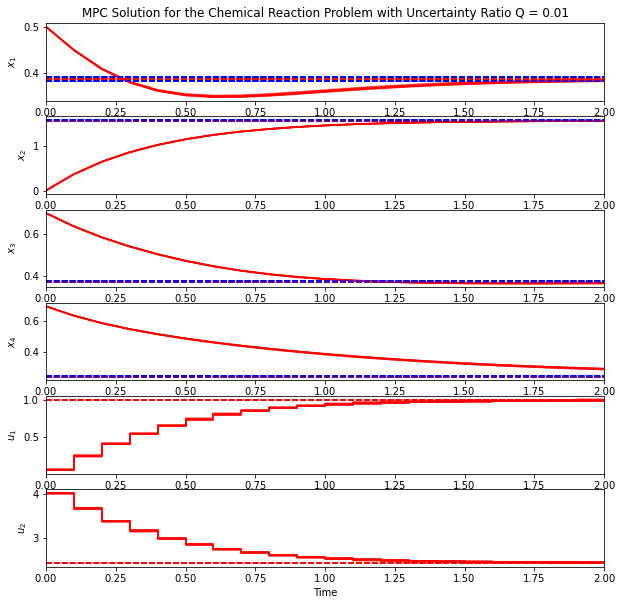

<Figure size 1008x1008 with 0 Axes>

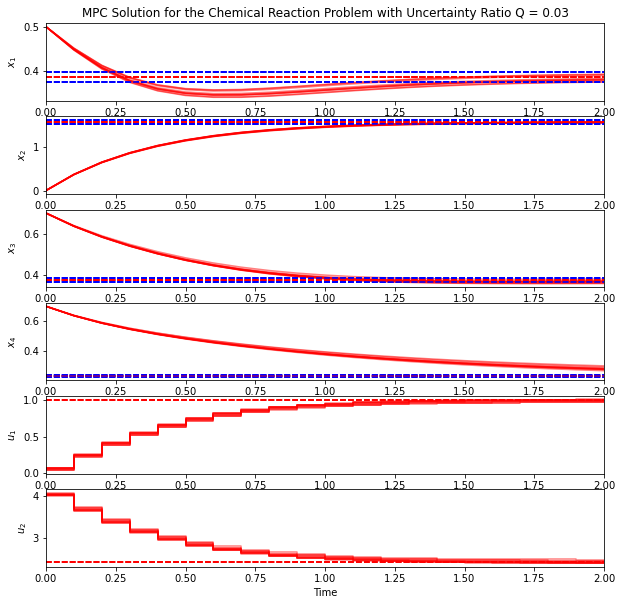

<Figure size 1008x1008 with 0 Axes>

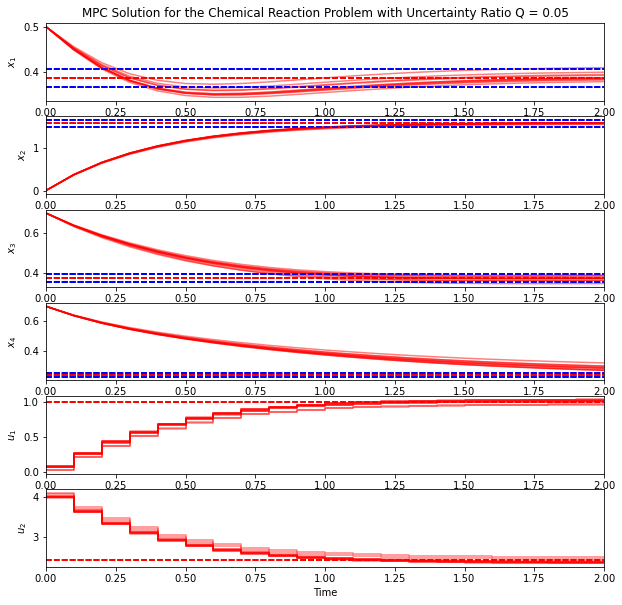

<Figure size 1008x1008 with 0 Axes>

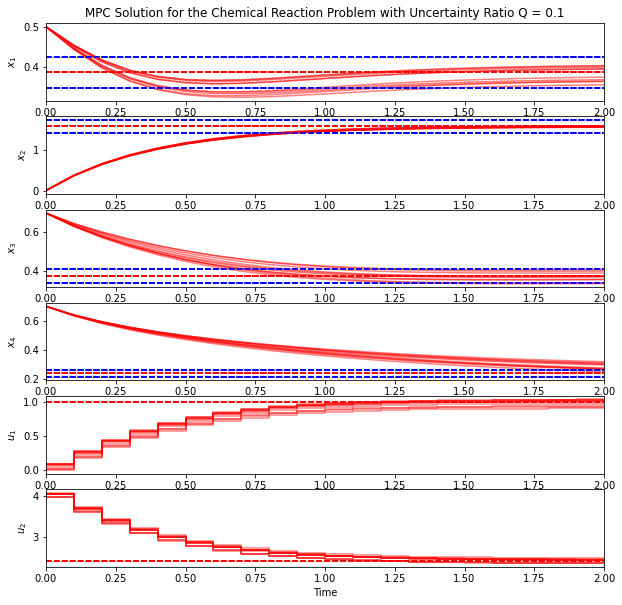

<Figure size 1008x1008 with 0 Axes>

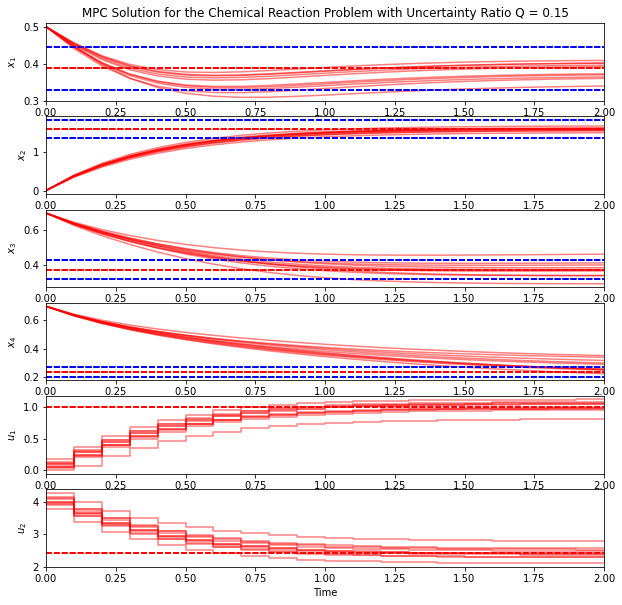

<Figure size 1008x1008 with 0 Axes>

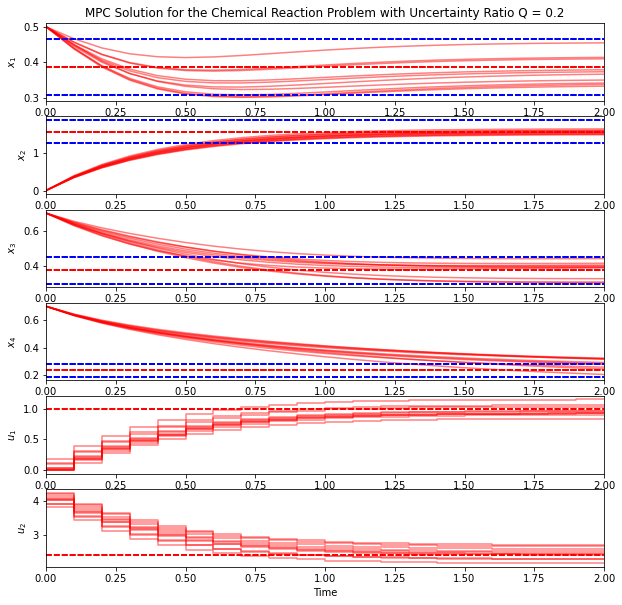

<Figure size 1008x1008 with 0 Axes>

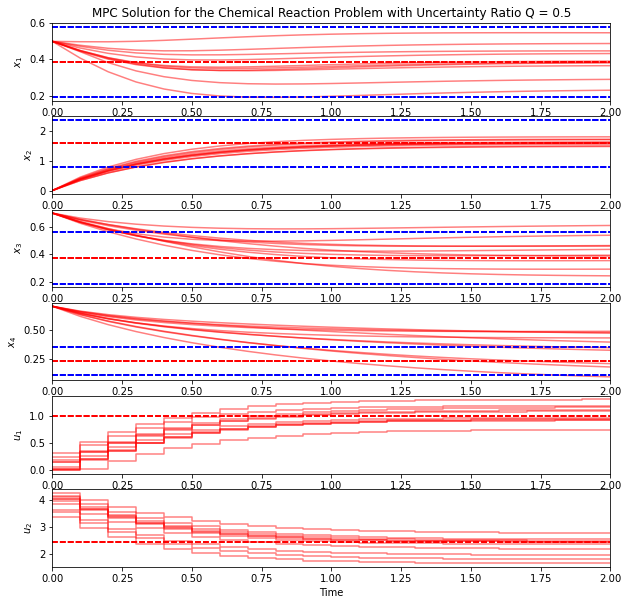

In [9]:


nx = 4
nu = 2
#ratio_arr = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]  # Q ratio = std / xs[ii]
ratio_arr = [0.0, 0.002, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.5]
num_trials = 10  # number of trials for each ratio
xs_Q_1 = [0.] * len(ratio_arr)
xs_Q_2 = [0.] * len(ratio_arr)
xs_Q_3 = [0.] * len(ratio_arr)
xs_Q_4 = [0.] * len(ratio_arr)
err_Q_1 = [0.] * len(ratio_arr)
err_Q_2 = [0.] * len(ratio_arr)
err_Q_3 = [0.] * len(ratio_arr)
err_Q_4 = [0.] * len(ratio_arr)
se_1 = [0.] * len(ratio_arr)
se_2 = [0.] * len(ratio_arr)
se_3 = [0.] * len(ratio_arr)
se_4 = [0.] * len(ratio_arr)
se = [0.] * len(ratio_arr)

for rr, ratio in enumerate(ratio_arr):
    print('*****************************')
    print(f"Starting to solve for Q = {round(ratio, 2)}")
    print('*****************************')
    std = [ratio * xs[ii] for ii in range(nx)]
    err_Q_1[rr], err_Q_2[rr], err_Q_3[rr], err_Q_4[rr], se_1[rr], se_2[rr], se_3[rr], se_4[rr] = noise_study(model, xs, us, ratio, T, N, dt, sigma, std, Q, R, ulb, uub, num_time_steps_sim, num_trials, nx, nu)

print('Loop finished!')

for rr in range(len(ratio_arr)):
    xs_Q_1[rr] = err_Q_1[rr] + xs[0]
    xs_Q_2[rr] = err_Q_2[rr] + xs[1]
    xs_Q_3[rr] = err_Q_3[rr] + xs[2]
    xs_Q_4[rr] = err_Q_4[rr] + xs[3]
    
    se[rr] = se_1[rr] + se_2[rr] + se_3[rr] + se_4[rr]
    


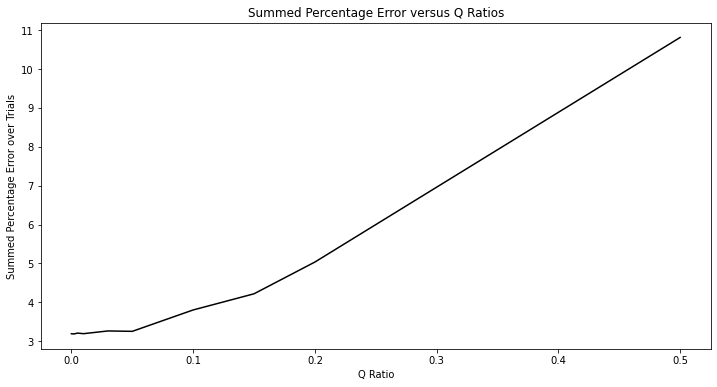

In [10]:
plt.figure(figsize=[12, 6])
plt.plot(ratio_arr, se, 'k-', label="Summed Percentage Error")
ttl = "Summed Percentage Error versus Q Ratios"
plt.title(ttl)
plt.xlabel("Q Ratio")
plt.ylabel("Summed Percentage Error over Trials")
save_path = folder + '/' + ttl + save_type
plt.savefig(save_path)

<Figure size 2016x1008 with 0 Axes>

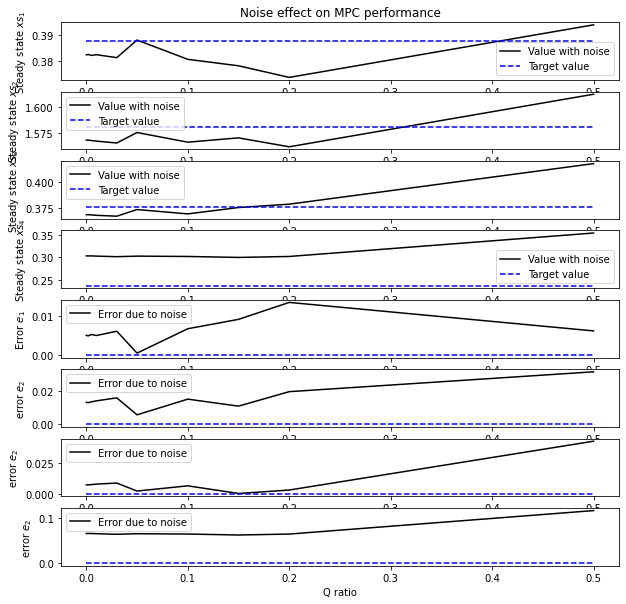

In [11]:
# plotting for overall xs_Q versus Q
plt.figure(figsize=[28, 14])
fig, axs = plt.subplots((2*nx), 1, figsize=[10, 10])
         
# state 1
axs[0].plot(ratio_arr, xs_Q_1, 'k-', label='Value with noise') 
axs[0].plot([ratio_arr[0], ratio_arr[-1]], [xs[0], xs[0]], 'b--', label='Target value')
axs[0].set_ylabel(f"Steady state $xs_1$")
axs[0].legend()
                        
# state 2
axs[1].plot(ratio_arr, xs_Q_2, 'k-', label='Value with noise') 
axs[1].plot([ratio_arr[0], ratio_arr[-1]], [xs[1], xs[1]], 'b--', label='Target value')
axs[1].set_ylabel(f"Steady state $xs_2$")
axs[1].legend()

# state 3
axs[2].plot(ratio_arr, xs_Q_3, 'k-', label='Value with noise') 
axs[2].plot([ratio_arr[0], ratio_arr[-1]], [xs[2], xs[2]], 'b--', label='Target value')
axs[2].set_ylabel(f"Steady state $xs_3$")
axs[2].legend()

# state 4
axs[3].plot(ratio_arr, xs_Q_4, 'k-', label='Value with noise') 
axs[3].plot([ratio_arr[0], ratio_arr[-1]], [xs[3], xs[3]], 'b--', label='Target value')
axs[3].set_ylabel(f"Steady state $xs_4$")
axs[3].legend()

# error 1
axs[4].plot(ratio_arr, np.abs(err_Q_1), 'k-', label='Error due to noise') 
axs[4].plot([ratio_arr[0], ratio_arr[-1]], [0.0, 0.0], 'b--')
axs[4].set_ylabel(f"Error $e_1$")
axs[4].legend()
                              
# error 2
axs[5].plot(ratio_arr, np.abs(err_Q_2), 'k-', label='Error due to noise') 
axs[5].plot([ratio_arr[0], ratio_arr[-1]], [0.0, 0.0], 'b--')
axs[5].set_ylabel(f"error $e_2$")
axs[5].legend()

# error 3
axs[6].plot(ratio_arr, np.abs(err_Q_3), 'k-', label='Error due to noise') 
axs[6].plot([ratio_arr[0], ratio_arr[-1]], [0.0, 0.0], 'b--')
axs[6].set_ylabel(f"error $e_2$")
axs[6].legend()

# error 4
axs[7].plot(ratio_arr, np.abs(err_Q_4), 'k-', label='Error due to noise') 
axs[7].plot([ratio_arr[0], ratio_arr[-1]], [0.0, 0.0], 'b--')
axs[7].set_ylabel(f"error $e_2$")
axs[7].legend()
                        
axs[-1].set_xlabel("Q ratio")
ttl = "Noise effect on MPC performance"
axs[0].set_title(ttl)

# save
save_path = folder + '/' + ttl + save_type
plt.savefig(save_path)
